In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from IPython.display import Image

In [3]:
sample_image_path = os.path.join(os.getcwd(), 'data', 'img', 'XwsouMoCN2h6wkN1HK9Fmw_90.jpg')

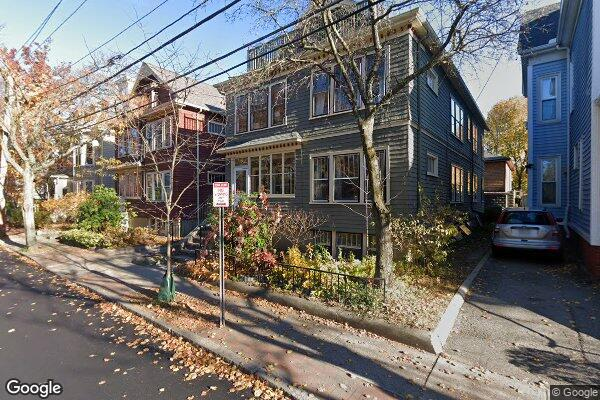

In [4]:
Image(sample_image_path)

## Testing Meta's Segment Anything

First download a model checkpoint [https://github.com/facebookresearch/segment-anything#model-checkpoints]

In [5]:
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
import cv2

ModuleNotFoundError: No module named 'segment_anything'

In [13]:
sam_checkpoint = "sam_vit_h_4b8939.pth"

model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# sam.to(device='cuda')

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
image = cv2.imread(sample_image_path)

In [16]:
# predictor = SamPredictor(sam)
# predictor.set_image(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:

- segmentation : the mask
- area : the area of the mask in pixels
- bbox : the boundary box of the mask in XYWH format
- predicted_iou : the model's own prediction for the quality of the mask
- point_coords : the sampled input point that generated this mask
- stability_score : an additional measure of mask quality
- crop_box : the crop of the image used to generate this mask in XYWH format

In [20]:
%%time
masks = mask_generator.generate(image)

In [21]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

NameError: name 'show_anns' is not defined

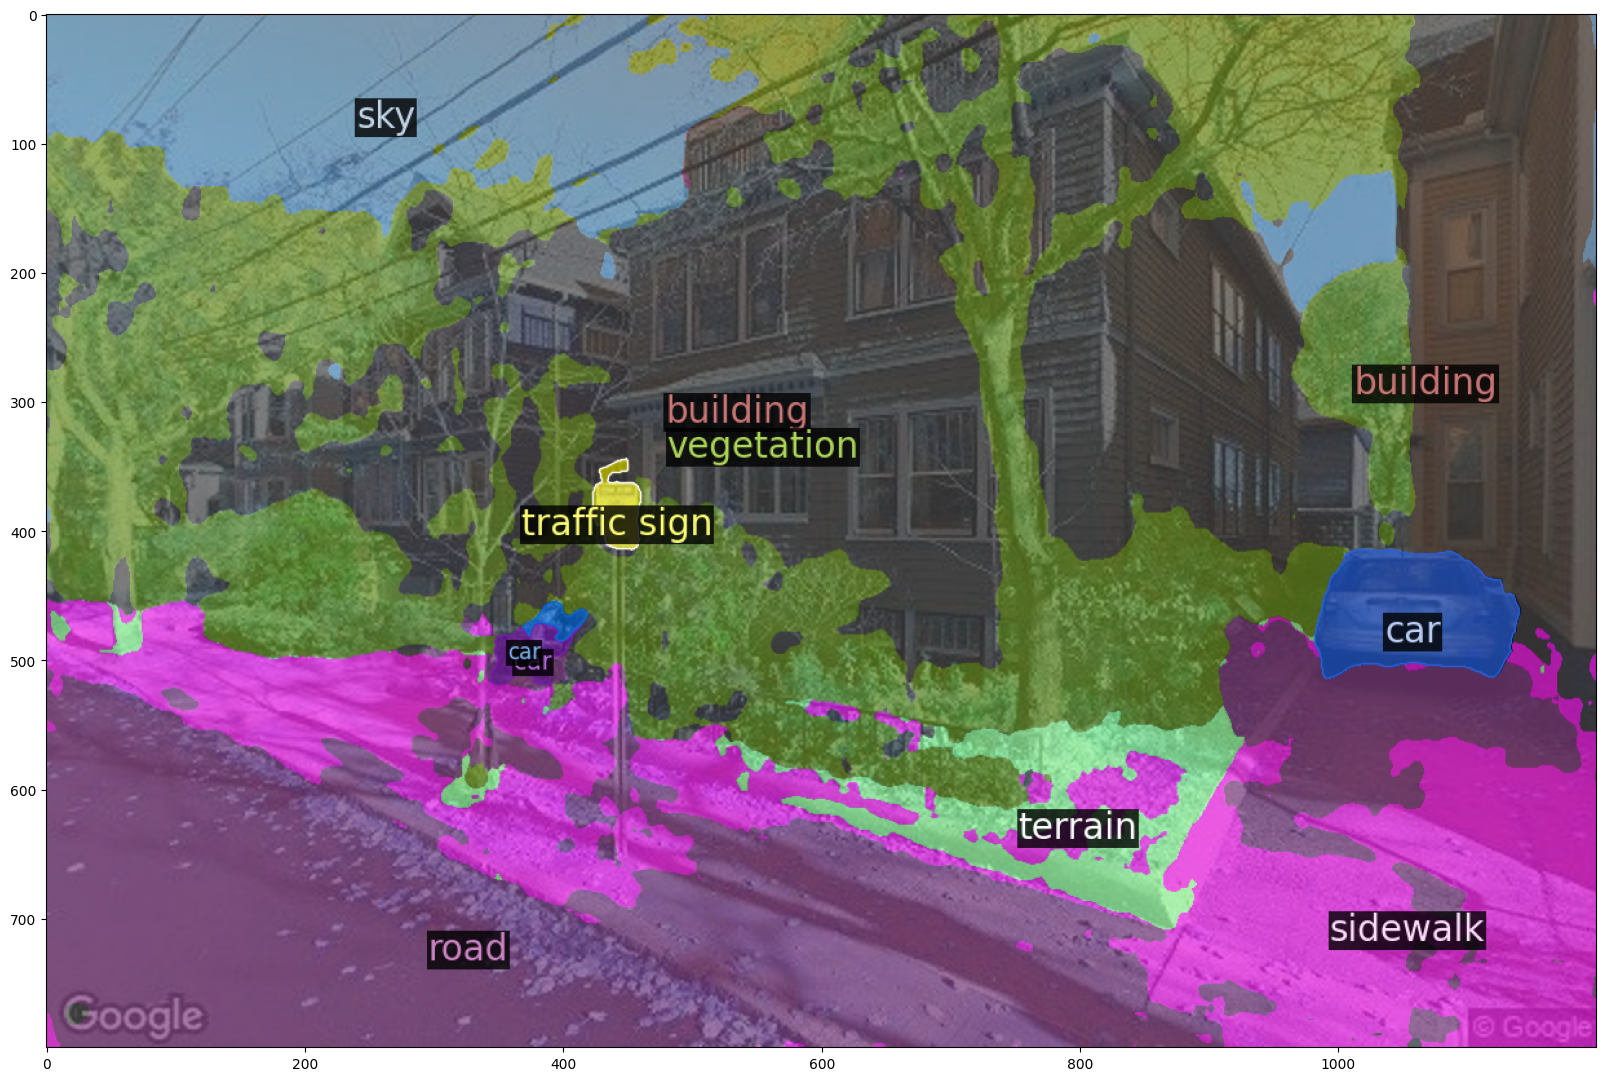

In [32]:
%%time

plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.savefig('metaseg_result.jpg')
plt.show()

In [24]:
print(len(masks))
print(masks[0].keys())

114
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [25]:
sorted_anns = sorted(masks, key=(lambda x: x['area']), reverse=True)

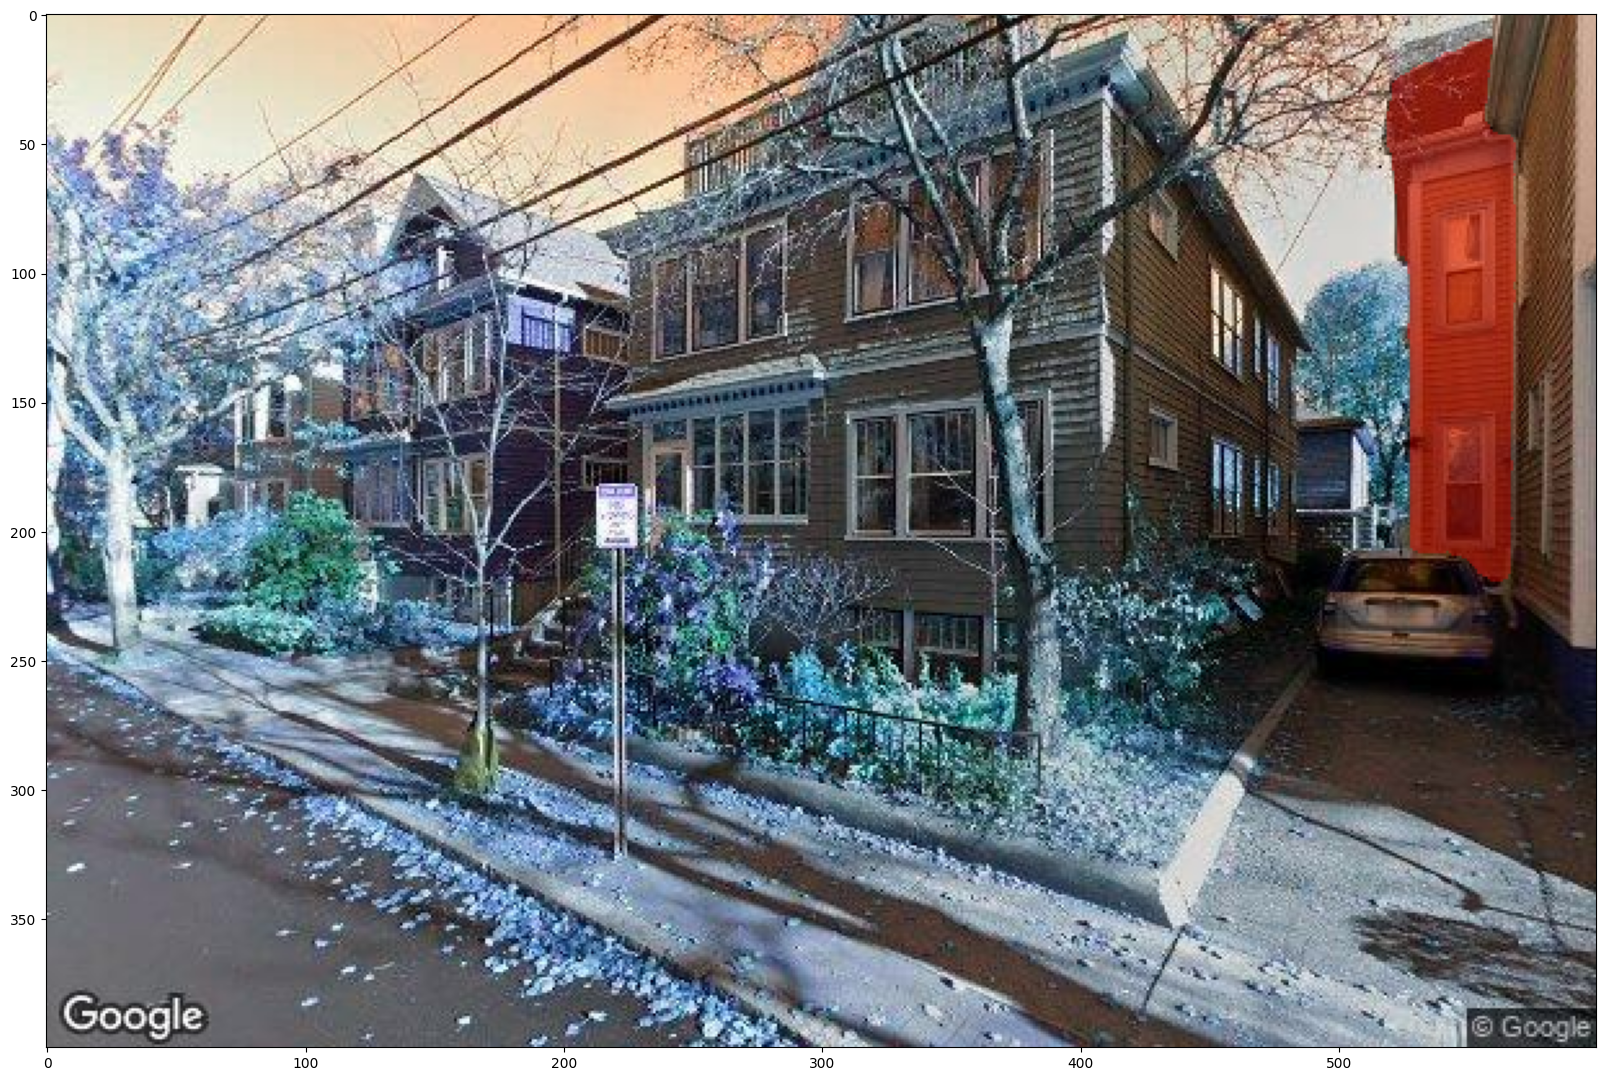

In [39]:
plt.figure(figsize=(20,20))
plt.imshow(image)

i = 6
ann = sorted_anns[i]
m = ann['segmentation']
img = np.ones((m.shape[0], m.shape[1], 3))
# color_mask = np.random.random((1, 3)).tolist()[0]
color_mask = [1, 0, 0]
for i in range(3):
    img[:,:,i] = color_mask[i]
ax = plt.gca()
ax.set_autoscale_on(False)
ax.imshow(np.dstack((img, m*0.35)))

## DETR fine tuning on Cityscapes dataset for panoptic segmentation
https://github.com/DanieleVeri/fair-DETR/blob/main/DETR.ipynb

Before starting, make sure you have the cityscapes fine dataset downloaded (https://www.cityscapes-dataset.com/downloads/)

In [18]:
# COCO Panoptic dataset
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
import detr
import json
from pathlib import Path
import numpy as np
import torch
from PIL import Image
from panopticapi.utils import rgb2id

In [5]:
np.__version__

'1.24.1'

### Dataset - COCO panoptic

A collection of scripts is used to download the Cityscapes dataset and convert it to the COCO format, allowing the reuse of the functions responsible for loading and parsing the dataset. - https://github.com/mcordts/cityscapesScripts
The used dataset (leftImg8bit_trainvaltest with gtFine labels) consist in an archive of 5000 images where about 3000 make the train set, 500 the validation set and 1500 the test set (unused).

In particular the COCO format [6] for panoptic segmentation consists in a PNG that stores the class-agnostic image segmentation and a JSON struct that stores the semantic information for each image segment. The unique id of the segment is used to retrieve the corresponding mask from the PNG while the category_id gives the semantic category. The isthing attribute distinguishes stuff and thing categories.
While the COCO dataset express segmentation as a list of vertex (that will be converted to the mask image) the Cityscapes script already outputs the PNG.

In [5]:
city2int = {
    "aachen": 0,
    "bremen": 1,
    "darmstadt": 2,
    "erfurt": 3,
    "hanover": 4,
    "krefeld": 5,
    "strasbourg": 6,
    "tubingen": 7,
    "weimar": 8,
    "bochum": 9,
    "cologne": 10,
    "dusseldorf": 11,
    "hamburg": 12,
    "jena": 13,
    "monchengladbach": 14,
    "stuttgart": 15,
    "ulm": 16,
    "zurich": 17,
    "frankfurt": 18,
    "lindau": 19,
    "munster":20,
    "berlin": 21,
    "bielefeld": 22,
    "bonn": 23,
    "leverkusen": 24,
    "mainz": 25,
    "munich": 26
}

int2city = {v: k for k, v in city2int.items()}

def imgid2int(id):
    city, f, s = id.split('_')
    return int(int(s) + int(f)*1e6 + city2int[city]*1e12)

def int2imgid(num):
    cityn = num // int(1e12)
    f = (num - int(cityn * 1e12)) // int(1e6)
    s = num % int(1e6)
    return int2city[cityn]+'_'+str(f).zfill(6)+'_'+str(s).zfill(6)

class CityscapesPanoptic:
    def __init__(self, img_folder, ann_folder, ann_file, transforms=None, return_masks=True):
        with open(ann_file, 'r') as f:
            self.coco = json.load(f)

        # sort 'images' field so that they are aligned with 'annotations'
        # i.e., in alphabetical order
        self.coco['images'] = sorted(self.coco['images'], key=lambda x: x['id'])

        self.img_folder = img_folder
        self.ann_folder = ann_folder
        self.ann_file = ann_file
        self.transforms = transforms
        self.return_masks = return_masks

    def __getitem__(self, idx):
        ann_info = self.coco['annotations'][idx] if "annotations" in self.coco else self.coco['images'][idx]
        city = ann_info['image_id'].split('_')[0]
        img_path = Path(self.img_folder) / city / (ann_info['image_id'] + "_leftImg8bit.png")
        ann_path = Path(self.ann_folder) / ann_info['file_name']

        img = Image.open(img_path).convert('RGB')
        w, h = img.size
        if "segments_info" in ann_info:
            masks = np.asarray(Image.open(ann_path), dtype=np.uint32)
            masks = rgb2id(masks)

            ids = np.array([ann['id'] for ann in ann_info['segments_info']])
            masks = masks == ids[:, None, None]

            masks = torch.as_tensor(masks, dtype=torch.uint8)
            labels = torch.tensor([ann['category_id'] for ann in ann_info['segments_info']], dtype=torch.int64)

        target = {}
        target['image_id'] = torch.tensor([imgid2int(ann_info['image_id'] if "image_id" in ann_info else ann_info["id"])])
        if self.return_masks:
            target['masks'] = masks
        target['labels'] = labels

        target["boxes"] = detr.masks_to_boxes(masks)

        target['size'] = torch.as_tensor([int(h), int(w)])
        target['orig_size'] = torch.as_tensor([int(h), int(w)])
        if "segments_info" in ann_info:
            for name in ['iscrowd', 'area']:
                target[name] = torch.tensor([ann[name] for ann in ann_info['segments_info']])

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.coco['images'])

    def get_height_and_width(self, idx):
        img_info = self.coco['images'][idx]
        height = img_info['height']
        width = img_info['width']
        return height, width

def build_cityscapes_panoptic(image_set, args):
    img_folder_root = Path(args.coco_path)
    ann_folder_root = Path(args.coco_panoptic_path)
    assert img_folder_root.exists(), f'provided path {img_folder_root} does not exist'
    assert ann_folder_root.exists(), f'provided path {ann_folder_root} does not exist'
    
    ann_file = {
        "train": "cityscapes/gtFine/cityscapes_panoptic_train.json",
        "val": "cityscapes/gtFine/cityscapes_panoptic_val.json"
    }

    img_folder_path = {
        "train": "cityscapes/leftImg8bit/train",
        "val": "cityscapes/leftImg8bit/val"
    }

    ann_folder = {
        "train": "cityscapes/gtFine/cityscapes_panoptic_train",
        "val": "cityscapes/gtFine/cityscapes_panoptic_val"
    }

    dataset = CityscapesPanoptic(img_folder_path[image_set], ann_folder[image_set], ann_file[image_set],
                           transforms=detr.make_coco_transforms(image_set), return_masks=args.masks)

    return dataset

import torch.utils.data
import torchvision

def build_dataset(image_set, args):
    if args.dataset_file == 'coco_panoptic':
        # to avoid making panopticapi required for coco
        return build_cityscapes_panoptic(image_set, args)
    raise ValueError(f'dataset {args.dataset_file} not supported')

### Evaluate 

In [6]:
"""
COCO evaluator that works in distributed mode.

Mostly copy-paste from https://github.com/pytorch/vision/blob/edfd5a7/references/detection/coco_eval.py
The difference is that there is less copy-pasting from pycocotools
in the end of the file, as python3 can suppress prints with contextlib
"""
import os
try:
    from panopticapi.evaluation import pq_compute
except ImportError:
    pass
from collections import OrderedDict, defaultdict, deque
import time
import datetime

class PanopticEvaluator(object):
    def __init__(self, ann_file, ann_folder, output_dir="panoptic_eval"):
        self.gt_json = ann_file
        self.gt_folder = ann_folder
        if not os.path.exists(output_dir):
            os.mkdir(output_dir)
        self.output_dir = output_dir
        self.predictions = []

    def update(self, predictions):
        for p in predictions:
            with open(os.path.join(self.output_dir, p["file_name"]), "wb") as f:
                f.write(p.pop("png_string"))
        self.predictions += predictions

    def synchronize_between_processes(self):
        return

    def summarize(self):
        json_data = {"annotations": self.predictions}
        predictions_json = os.path.join(self.output_dir, "predictions.json")
        with open(predictions_json, "w") as f:
            f.write(json.dumps(json_data))
        # self.gt_json is the ann_file, pq_compute
        return pq_compute(self.gt_json, predictions_json, gt_folder=self.gt_folder, pred_folder=self.output_dir)


class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        return


    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)

def collate_fn(batch):
    batch = list(zip(*batch))
    batch[0] = detr.nested_tensor_from_tensor_list(batch[0])
    return tuple(batch)

def save_on_master(*args, **kwargs):
    torch.save(*args, **kwargs)
        
class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        if torch.cuda.is_available():
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}',
                'max mem: {memory:.0f}'
            ])
        else:
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}'
            ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.4f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))

def log_class_chart(results):
    id2name = {  
        0: 'unlabeled'           ,
        1: 'ego vehicle'         ,
        2: 'rectification border',
        3: 'out of roi'          ,
        4: 'static'              ,
        5: 'dynamic'             ,
        6: 'ground'              ,
        7: 'road'                ,
        8: 'sidewalk'            ,
        9: 'parking'             ,
        10: 'rail track'          ,
        11: 'building'            ,
        12: 'wall'                ,
        13: 'fence'               ,
        14: 'guard rail'          ,
        15: 'bridge'              ,
        16: 'tunnel'              ,
        17: 'pole'                ,
        18: 'polegroup'           ,
        19: 'traffic light'       ,
        20: 'traffic sign'        ,
        21: 'vegetation'          ,
        22: 'terrain'             ,
        23: 'sky'                 ,
        24: 'person'              ,
        25: 'rider'               ,
        26: 'car'                 ,
        27: 'truck'               ,
        28: 'bus'                 ,
        29: 'caravan'             ,
        30: 'trailer'             ,
        31: 'train'               ,
        32: 'motorcycle'          ,
        33: 'bicycle'             
    }

    cl = results['per_class']

    plt.figure(figsize=(10, 20), dpi=80)

    for k in cl.keys():
        c = cl[k]
        plt.barh(id2name[k]+'_pq', c['pq'], color = 'violet')
        plt.barh(id2name[k]+'_sq', c['sq'], color = 'red')
        plt.barh(id2name[k]+'_rq', c['rq'], color = 'blue')

    plt.savefig('chart.png')
    plt.show()
    # wandb.log({"chart": wandb.Image(Image.open('chart.png'))})

@torch.no_grad()
def evaluate(model, criterion, postprocessors, data_loader, device, output_dir):
    model.eval()
    criterion.eval()

    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('class_error', SmoothedValue(window_size=1, fmt='{value:.2f}'))
    header = 'Test:'

    panoptic_evaluator = None
    if 'panoptic' in postprocessors.keys():
        panoptic_evaluator = PanopticEvaluator(
            data_loader.dataset.ann_file,
            data_loader.dataset.ann_folder,
            output_dir=os.path.join(output_dir, "panoptic_eval"),
        )
        
    for samples, targets in metric_logger.log_every(data_loader, 10, header):
        samples = samples.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(samples)
        loss_dict = criterion(outputs, targets)
        weight_dict = criterion.weight_dict

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = loss_dict
        loss_dict_reduced_scaled = {k: v * weight_dict[k]
                                    for k, v in loss_dict_reduced.items() if k in weight_dict}
        loss_dict_reduced_unscaled = {f'{k}_unscaled': v
                                      for k, v in loss_dict_reduced.items()}
        metric_logger.update(loss=sum(loss_dict_reduced_scaled.values()),
                             **loss_dict_reduced_scaled,
                             **loss_dict_reduced_unscaled)
        metric_logger.update(class_error=loss_dict_reduced['class_error'])

        orig_target_sizes = torch.stack([t["orig_size"] for t in targets], dim=0)
        results = postprocessors['bbox'](outputs, orig_target_sizes)
        if 'segm' in postprocessors.keys():
            target_sizes = torch.stack([t["size"] for t in targets], dim=0)
            results = postprocessors['segm'](results, outputs, orig_target_sizes, target_sizes)
        res = {int2imgid(target['image_id'].item()): output for target, output in zip(targets, results)}

        if panoptic_evaluator is not None:
            res_pano = postprocessors["panoptic"](outputs, target_sizes, orig_target_sizes)
            for i, target in enumerate(targets):
                image_id = int2imgid(target["image_id"].item())
                file_name = f"{image_id}.png"
                res_pano[i]["image_id"] = image_id
                res_pano[i]["file_name"] = file_name

            panoptic_evaluator.update(res_pano)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)

    # accumulate predictions from all images
    panoptic_res = None
    if panoptic_evaluator is not None:
        panoptic_res = panoptic_evaluator.summarize()
    log_class_chart(panoptic_res)
    stats = {k: meter.global_avg for k, meter in metric_logger.meters.items()}

    if panoptic_res is not None:
        stats['PQ_all'] = panoptic_res["All"]
        stats['PQ_th'] = panoptic_res["Things"]
        stats['PQ_st'] = panoptic_res["Stuff"]
    return stats

### Train loop 

In [7]:
"""
Train and eval functions used in main.py
"""
from torch.utils.data import DataLoader, DistributedSampler
import math
import sys
import time 
import datetime
from typing import Iterable

def train_one_epoch(model: torch.nn.Module, criterion: torch.nn.Module,
                    data_loader: Iterable, optimizer: torch.optim.Optimizer,
                    device: torch.device, epoch: int, max_norm: float = 0):
    model.train()
    criterion.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    metric_logger.add_meter('class_error', SmoothedValue(window_size=1, fmt='{value:.2f}'))
    header = 'Epoch: [{}]'.format(epoch)
    print_freq = 10 

    for samples, targets in metric_logger.log_every(data_loader, print_freq, header):
        samples = samples.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(samples)
        loss_dict = criterion(outputs, targets)

        weight_dict = criterion.weight_dict
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = loss_dict
        loss_dict_reduced_unscaled = {f'{k}_unscaled': v
                                      for k, v in loss_dict_reduced.items()}
        loss_dict_reduced_scaled = {k: v * weight_dict[k]
                                    for k, v in loss_dict_reduced.items() if k in weight_dict}
        losses_reduced_scaled = sum(loss_dict_reduced_scaled.values())

        loss_value = losses_reduced_scaled.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        if max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()

        metric_logger.update(loss=loss_value, **loss_dict_reduced_scaled, **loss_dict_reduced_unscaled)
        metric_logger.update(class_error=loss_dict_reduced['class_error'])
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

        # if ENABLE_WANDB:
        #     wandb.log(loss_dict_reduced)
        #     wandb.log({'loss':loss_value})
            
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}

def train():
    if args.frozen_weights is not None:
        assert args.masks, "Frozen training is meant for segmentation only"
    print(args)

    !mkdir out_dir/panoptic_eval -p

    model, criterion, postprocessors = build_pretrained_model(args)
    model.to(device)

    # if ENABLE_WANDB:
    #     wandb.watch(model)

    model_without_ddp = model

    n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('number of params:', n_parameters)

    param_dicts = [
        {"params": [p for n, p in model_without_ddp.named_parameters() if "backbone" not in n and p.requires_grad]},
        {
            "params": [p for n, p in model_without_ddp.named_parameters() if "backbone" in n and p.requires_grad],
            "lr": args.lr_backbone,
        },
    ]
    optimizer = torch.optim.AdamW(param_dicts, lr=args.lr,
                                    weight_decay=args.weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args.lr_drop)

    if used_artifact is not None:
        artifact_dir = "detr_checkpoints"
        checkpoint = torch.load(artifact_dir+"/checkpoint.pth", map_location=device)
        model.load_state_dict(checkpoint['model'])
        if run_id is not None:
            optimizer.load_state_dict(checkpoint['optimizer'])
        # lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
        start_epoch = checkpoint['epoch']
    else:
        start_epoch = 0

    # if ENABLE_WANDB and used_artifact is not None:
    #     artifact = wandb.use_artifact(used_artifact)
    #     artifact_dir = artifact.download()
    #     checkpoint = torch.load(artifact_dir+"/checkpoint.pth")

    #     model.load_state_dict(checkpoint['model'])
    #     if run_id is not None:
    #         optimizer.load_state_dict(checkpoint['optimizer'])
    #     # lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    #     start_epoch = checkpoint['epoch']
    # else:
    #     start_epoch = 0

    dataset_train = build_dataset(image_set='train', args=args)
    dataset_val = build_dataset(image_set='val', args=args)

    sampler_train = torch.utils.data.RandomSampler(dataset_train)
    sampler_val = torch.utils.data.SequentialSampler(dataset_val)

    batch_sampler_train = torch.utils.data.BatchSampler(
        sampler_train, args.batch_size, drop_last=True)

    data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                                    collate_fn=collate_fn, num_workers=1)
    data_loader_val = DataLoader(dataset_val, args.batch_size, sampler=sampler_val,
                                    drop_last=False, collate_fn=collate_fn, num_workers=1)


    if args.frozen_weights is not None:
        checkpoint = torch.load(args.frozen_weights, map_location='cpu')
        model_without_ddp.detr.load_state_dict(checkpoint['model'])

    output_dir = Path(args.output_dir)

    if args.eval:
        test_stats = evaluate(model, criterion, postprocessors,
                                                data_loader_val, device, args.output_dir)
        print(test_stats)
        return

    print("Start training")
    start_time = time.time()
    for epoch in range(start_epoch+1,args.epochs):
        train_stats = train_one_epoch(
            model, criterion, data_loader_train, optimizer, device, epoch,
            args.clip_max_norm)
        
        lr_scheduler.step()

        if args.output_dir:
            checkpoint_path = output_dir / 'checkpoint.pth'
            save_on_master({
                'model': model_without_ddp.state_dict(),
                'optimizer': optimizer.state_dict(),
                'lr_scheduler': lr_scheduler.state_dict(),
                'epoch': epoch,
                'args': args,
            }, checkpoint_path)
            # if ENABLE_WANDB:
            #     artifact = wandb.Artifact(wandb_experiment_name, type='model')
            #     artifact.add_file(checkpoint_path)
            #     wandb.log_artifact(artifact)

        test_stats = evaluate(
            model, criterion, postprocessors, data_loader_val, device, args.output_dir
        )

        log_stats = {**{f'train_{k}': v for k, v in train_stats.items()},
                        **{f'test_{k}': v for k, v in test_stats.items()},
                        'epoch': epoch,
                        'n_parameters': n_parameters}
        # if ENABLE_WANDB:
        #     wandb.log(test_stats)

        if args.output_dir:
            with (output_dir / "log.txt").open("a") as f:
                f.write(json.dumps(log_stats) + "\n")

    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print('Training time {}'.format(total_time_str))

### Confguration and start

In [8]:
import random
import numpy as np
import torch

seed = 42

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms(False)     # missing some deterministic impl

device = torch.device("cpu")
# device = torch.device("cuda:0")

class Args:
    pass
args = Args()
# Postitional encoding
args.position_embedding = "sine"
# CNN Backbone
args.backbone = "resnet50"
args.dilation = None
# Hungarian matcher
args.set_cost_class = 1
args.set_cost_bbox = 5
args.set_cost_giou = 2
# Transformer
args.hidden_dim = 256
args.dropout = 0.1
args.nheads = 8
args.dim_feedforward = 2048
args.enc_layers = 6
args.dec_layers = 6
args.pre_norm = None
# DETR
args.num_queries = 100
args.aux_loss = True # calculate loss at eache decoder layer
args.masks = True
args.frozen_weights = None
args.bbox_loss_coef = 5
args.mask_loss_coef = 1
args.dice_loss_coef = 1
args.giou_loss_coef = 2
args.eos_coef = 0.1
# Dataset
args.dataset_file = "coco_panoptic" # cityscape
args.coco_path = ""
args.coco_panoptic_path = ""
# Training
args.lr = 1e-4
args.weight_decay = 1e-4
args.lr_backbone = 0    # 0 means frozen backbone
args.batch_size = 1
args.epochs = 300
args.lr_drop = 200
args.clip_max_norm = 0.1

args.output_dir = "out_dir"
args.eval = False

Transfer learning policies

In [9]:
def freeze_attn(model, args):
    for i in range(args.dec_layers):
       for param in model.detr.transformer.decoder.layers[i].self_attn.parameters():
           param.requires_grad = False
       for param in model.detr.transformer.decoder.layers[i].multihead_attn.parameters():
           param.requires_grad = False

    for i in range(args.enc_layers):
        for param in model.detr.transformer.encoder.layers[i].self_attn.parameters():
           param.requires_grad = False

def freeze_decoder(model, args):
    for param in model.detr.transformer.decoder.parameters():
        param.requires_grad = False

def freeze_first_layers(model, args):
    for i in range(args.enc_layers // 2):
        for param in model.detr.transformer.encoder.layers[i].parameters():
            param.requires_grad = False

    for i in range(args.dec_layers // 2):
        for param in model.detr.transformer.decoder.layers[i].parameters():
            param.requires_grad = False


def build_pretrained_model(args):
    pre_trained = torch.hub.load('facebookresearch/detr', 'detr_resnet50_panoptic', pretrained=True, return_postprocessor=False, num_classes=250)
    model, criterion, postprocessors = detr.build_model(args)

    model.detr.backbone.load_state_dict(pre_trained.detr.backbone.state_dict())
    model.detr.bbox_embed.load_state_dict(pre_trained.detr.bbox_embed.state_dict())
    model.detr.query_embed.load_state_dict(pre_trained.detr.query_embed.state_dict())
    model.detr.input_proj.load_state_dict(pre_trained.detr.input_proj.state_dict())
    model.detr.transformer.load_state_dict(pre_trained.detr.transformer.state_dict())
 
    model.bbox_attention.load_state_dict(pre_trained.bbox_attention.state_dict())
    model.mask_head.load_state_dict(pre_trained.mask_head.state_dict())
    
    freeze_attn(model, args)

    return model, criterion, postprocessors

In [7]:
used_artifact = '2_2_attentionfreeze_aux:latest' 
run_id = None  

Train

In [ ]:
train()

### Validate

Before running, install visualization tools:
```
pip install 'git+https://github.com/facebookresearch/detectron2.git' > /dev/null
pip install pyyaml==5.1 > /dev/null

```

In [10]:
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import torchvision.transforms as T

Load model

In [11]:
# artifact = wandb.use_artifact(used_artifact)
# artifact_dir = artifact.download()
artifact_dir = "detr_checkpoints"
checkpoint = torch.load(artifact_dir+"/checkpoint.pth", map_location=torch.device('cpu'))

model, criterion, postprocessors = detr.build_model(args)
model.load_state_dict(checkpoint['model'])
model.eval();

transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

c:\Users\zoelh\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\zoelh\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
im = Image.open(sample_image_path)
img = transform(im).unsqueeze(0)
out = model(img)
result = postprocessors['panoptic'](out, torch.as_tensor(img.shape[-2:]).unsqueeze(0))[0]

c:\Users\zoelh\GitRepos\synthetic-matereals\detr.py:946: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  torch.ByteTensor(torch.ByteStorage.from_buffer(seg_img.tobytes()))


Attention plot

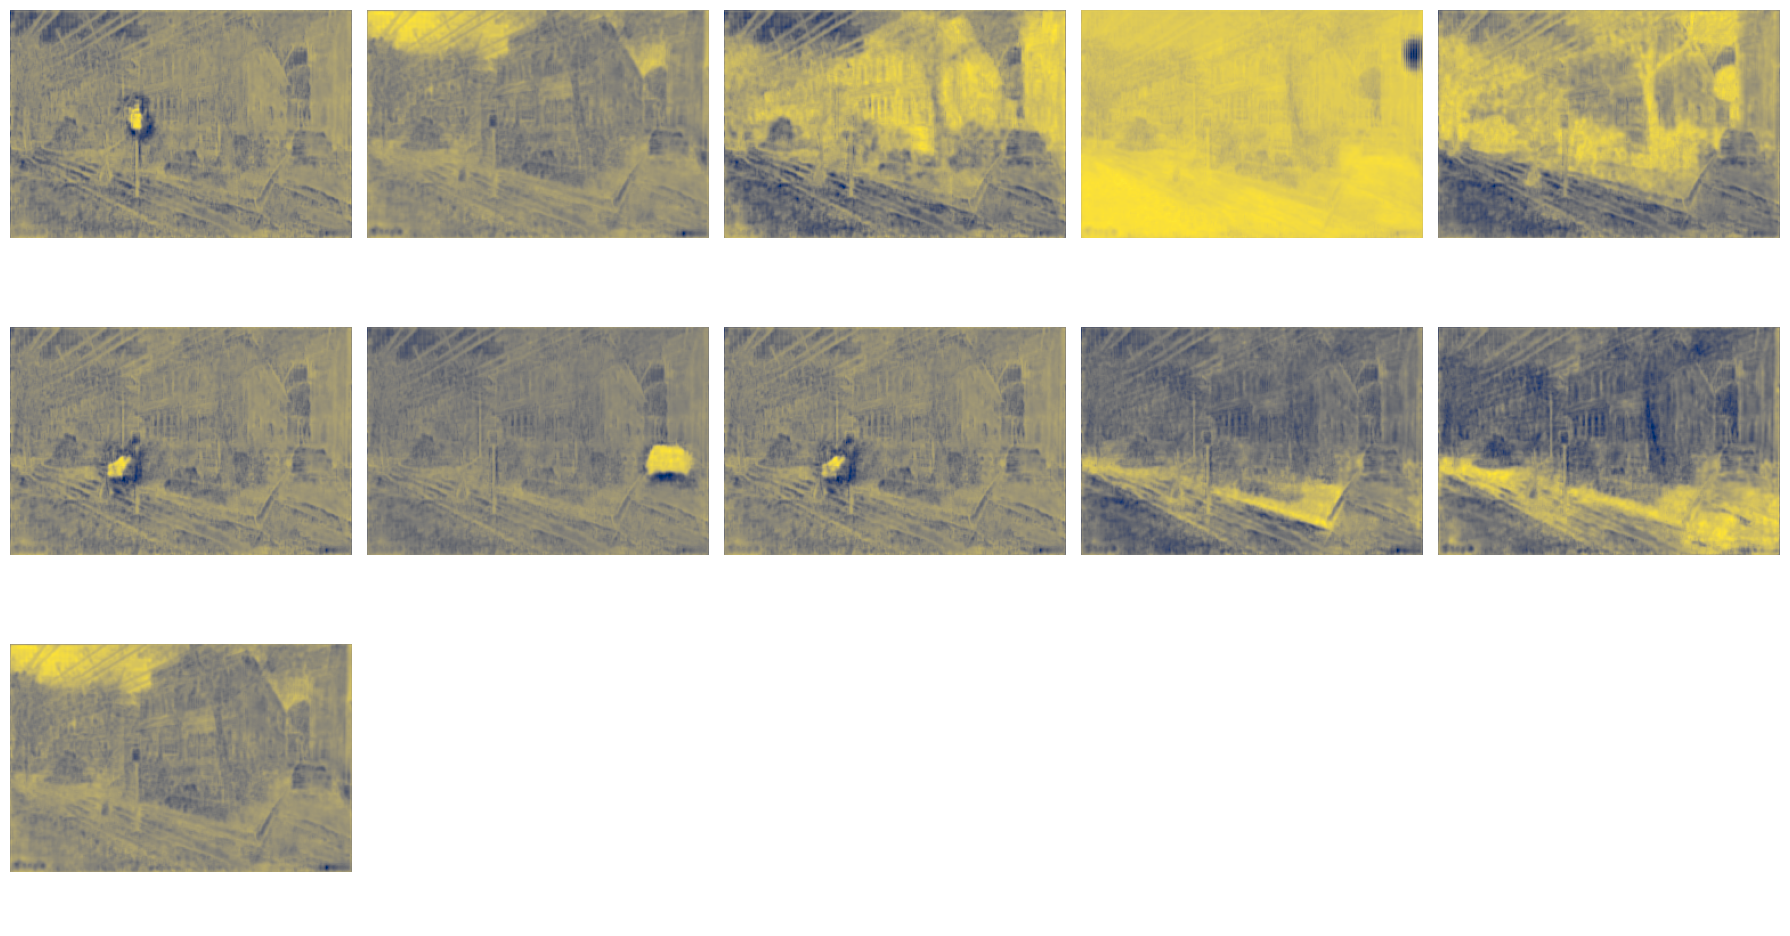

In [15]:
import matplotlib.pyplot as plt
scores = out["pred_logits"].softmax(-1)[..., :-1].max(-1)[0]
# threshold the confidence
keep = scores > 0.85

# Plot all the remaining masks
ncols = 5
fig, axs = plt.subplots(ncols=ncols, nrows=math.ceil(keep.sum().item() / ncols), figsize=(18, 10))
for line in axs:
    for a in line:
        a.axis('off')
for i, mask in enumerate(out["pred_masks"][keep]):
    ax = axs[i // ncols, i % ncols]
    ax.imshow(mask.detach().numpy(), cmap="cividis")
    ax.axis('off')
fig.tight_layout()

Visualize!

In [16]:
from copy import deepcopy
import io
# We extract the segments info and the panoptic result from DETR's prediction
segments_info = deepcopy(result["segments_info"])
# Panoptic predictions are stored in a special format png
panoptic_seg = Image.open(io.BytesIO(result['png_string']))
final_w, final_h = panoptic_seg.size
# We convert the png into an segment id map
panoptic_seg = np.array(panoptic_seg, dtype=np.uint8)
panoptic_seg = torch.from_numpy(rgb2id(panoptic_seg))

meta = MetadataCatalog.get("cityscapes_fine_panoptic_val")
for i in range(len(segments_info)):
    c = segments_info[i]["category_id"]
    segments_info[i]["category_id"] = meta.thing_dataset_id_to_contiguous_id[c] if segments_info[i]["isthing"] else meta.stuff_dataset_id_to_contiguous_id[c]

# Finally we visualize the prediction
v = Visualizer(np.array(im.copy().resize((final_w, final_h)))[:, :, ::-1], meta, scale=1.0)
v._default_font_size = 20
v = v.draw_panoptic_seg_predictions(panoptic_seg, segments_info, area_threshold=0)
image = v.get_image()
# im

In [ ]:
building_id = 11

In [25]:
out.keys()

dict_keys(['pred_logits', 'pred_boxes', 'aux_outputs', 'pred_masks'])

In [30]:
result.keys()

dict_keys(['png_string', 'segments_info'])

In [31]:
result['segments_info']

[{'id': 0, 'isthing': False, 'category_id': 20, 'area': 1889},
 {'id': 1, 'isthing': False, 'category_id': 23, 'area': 76045},
 {'id': 2, 'isthing': False, 'category_id': 11, 'area': 283944},
 {'id': 3, 'isthing': False, 'category_id': 7, 'area': 188050},
 {'id': 4, 'isthing': False, 'category_id': 21, 'area': 250258},
 {'id': 5, 'isthing': True, 'category_id': 26, 'area': 1698},
 {'id': 6, 'isthing': True, 'category_id': 26, 'area': 12476},
 {'id': 7, 'isthing': True, 'category_id': 26, 'area': 692},
 {'id': 8, 'isthing': False, 'category_id': 22, 'area': 23466},
 {'id': 9, 'isthing': False, 'category_id': 8, 'area': 121482}]

In [17]:
import cv2
# cv2.imshow('image', image)
cv2.imwrite('result.jpg', image)

True

## Auto-Context Segmentation

From "Efficient Facade Segmentation using Auto-Context" by Jampani∗, Gadde∗, and Gehler
https://files.is.tue.mpg.de/vjampani/jampani15_wacv.pdf

The system consists of three iterative sequences of boosted decision tree classifiers.
The maximum tree-depth of each classifier is set to 2 and we used a maximum of 200 boosting rounds.

## Testing Detectron2

## Testing DPT

In [45]:
from dpt_segmentation.dpt.models import DPTSegmentationModel
from dpt_segmentation.dpt.transforms import Resize, NormalizeImage, PrepareForNet
from torchvision.transforms import Compose
import torch

model_path = "dpt_segmentation/dpt_hybrid-ade20k-53898607.pt"
model_type = 'dpt_hybrid'
optimize = True

In [43]:
#INITIALIZE MODEL
"""Run segmentation network

Args:
    input_path (str): path to input folder
    output_path (str): path to output folder
    model_path (str): path to saved model
"""
print("initialize")

# select device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("device: %s" % device)
device = torch.device("cpu")

net_w = net_h = 480

# load network
if model_type == "dpt_large":
    model = DPTSegmentationModel(
        150,
        path=model_path,
        backbone="vitl16_384",
    )
elif model_type == "dpt_hybrid":
    model = DPTSegmentationModel(
        150,
        path=model_path,
        backbone="vitb_rn50_384",
    )
else:
    assert (
        False
    ), f"model_type '{model_type}' not implemented, use: --model_type [dpt_large|dpt_hybrid]"

transform = Compose(
    [
        Resize(
            net_w,
            net_h,
            resize_target=None,
            keep_aspect_ratio=True,
            ensure_multiple_of=32,
            resize_method="minimal",
            image_interpolation_method=cv2.INTER_CUBIC,
        ),
        NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        PrepareForNet(),
    ]
)

model.eval()

# if optimize == True and device == torch.device("cuda"):
#     model = model.to(memory_format=torch.channels_last)
#     model = model.half()

# model.to(device)

initialize


DPTSegmentationModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): HybridEmbed(
        (backbone): ResNetV2(
          (stem): Sequential(
            (conv): StdConv2dSame(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
            (norm): GroupNormAct(
              32, 64, eps=1e-05, affine=True
              (drop): Identity()
              (act): ReLU(inplace=True)
            )
            (pool): MaxPool2dSame(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
          )
          (stages): Sequential(
            (0): ResNetStage(
              (blocks): Sequential(
                (0): Bottleneck(
                  (downsample): DownsampleConv(
                    (conv): StdConv2dSame(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                    (norm): GroupNormAct(
                      32, 256, eps=1e-05, affine=True
                      (drop): Identity()
                      (act): 

In [52]:
# input
from dpt_segmentation.util import io

scores = []

img = io.read_image(sample_image_path)
img_input = transform({"image": img})["image"]

# compute
with torch.no_grad():
    sample = torch.from_numpy(img_input).unsqueeze(0)
    # sample = torch.from_numpy(img_input).to(device).unsqueeze(0)
    # if optimize == True and device == torch.device("cuda"):
    #     sample = sample.to(memory_format=torch.channels_last)
    #     sample = sample.half()

    out = model.forward(sample)

    prediction = torch.nn.functional.interpolate(
        out, size=img.shape[:2], mode="bicubic", align_corners=False
    )
    prediction = torch.argmax(prediction, dim=1) + 1
    prediction = prediction.squeeze().cpu().numpy()

    for j in range(1,151):
        score = prediction[prediction == j].size/prediction.size
        scores.append(score)

In [51]:
labels = ['wall', 'building', 'sky', 'floor', 'tree', 'ceiling', 'road', 'bed', 'window', 
          'grass', 'cabinet', 'sidewalk', 'person', 'earth', 'door', 'table', 'mountain', 
          'plant', 'curtain', 'chair', 'car', 'water', 'painting', 'sofa', 'shelf', 'house', 
          'sea', 'mirror', 'rug', 'field', 'armchair', 'seat', 'fence', 'desk', 'rock', 'wardrobe', 
          'lamp', 'bathtub', 'railing', 'cushion', 'base', 'box', 'column', 'signboard', 'dresser', 
          'counter', 'sand', 'sink', 'skyscraper', 'fireplace', 'refrigerator', 'grandstand', 'path', 
          'stairs', 'runway', 'case', 'pooltable', 'pillow', 'screen', 'stairway', 'river', 'bridge', 
          'bookcase', 'blind', 'coffeetable', 'toilet', 'flower', 'book', 'hill', 'bench', 
          'countertop', 'stove', 'palmtree', 'kitchen', 'computer', 'swivelchair', 'boat', 'bar', 
          'arcade', 'hut', 'bus', 'towel', 'light', 'truck', 'tower', 'chandelier', 'awning', 
          'streetlight', 'booth', 'television', 'airplane', 'dirttrack', 'apparel', 'pole', 'land', 
          'balustrade', 'escalator', 'ottoman', 'bottle', 'sideboard', 'poster', 'stage', 'van', 'ship', 
          'fountain', 'conveyerbelt', 'canopy', 'washer', 'toy', 'pool', 'stool', 'barrel', 'basket', 
          'waterfall', 'tent', 'bag', 'motorbike', 'cradle', 'oven', 'ball', 'food', 'step', 'tank', 
          'brandname', 'microwave', 'pot', 'animal', 'bicycle', 'lake', 'dishwasher', 'screen', 'blanket', 
          'sculpture', 'hood', 'sconce', 'vase', 'trafficlight', 'tray', 'trashcan', 'fan', 'pier', 
          'crtscreen', 'plate', 'monitor', 'bulletinboard', 'shower', 'radiator', 'glass', 'clock', 'flag']

In [53]:
scores[1]

0.044083333333333335